**DATA**

San Juan Dengue data from 1990-2008, in weeks. Therefore we have 936 weeks indexed from 1....936


**MODEL**

Neural net -- well it is a neural net ...so ... you know

Neural net w SIR -- Fit SIR model to data, train a neural net to fit the results from the SIR fitting, fix all weights of the NN EXCEPT for the output layer, train to actual data. This forces the NN to produce functions that are SIR-like.


**SET-UP**


We fit both models on a series of time zeroes, and forecast **20** steps ahead **using the correct input (i.e. the previous observed $Y_{t-4},Y_{t-3},Y_{t-2},Y_{t-1}$) for t+1...t+20** 

Why in the world would we do this? Well the training data is already split into $input: Y_{t-4},Y_{t-3},Y_{t-2},Y_{t-1} \rightarrow output: Y_t$ so when we forecast we use the true values for the input. This could easily not be the best way to validate it. 

**RESULTS**

| T_0 | Neural Net | SIR - Pretrained NN |
|:---: |:----------:| :------------------:|
| 400| **52** | 59|
| 425| 84 | **79**|
| 450|**5** | 6|
| 475|97 | **85**| 
| 500|114 | **109**| 
| 525|**299** | 437|
| 550|5007 | **4313**|
| 575|**228** | 331|
| 600|134| **125**|
| 625| 47 | **38**|
| 650|36 | **34**|
|675| 36 | **30**|
|total|6145 | **5649**|

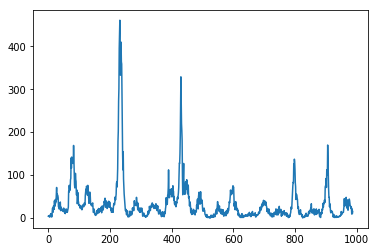

In [29]:
import sys
import numpy as np
import matplotlib.pyplot as plt
data = []
count = 0
with open ("/Users/gcgibson/Downloads/San_Juan_Training_Data.csv") as f:
        for line in f.readlines():
            if count > 0:
                data.append(line.replace("\n","").split(',')[-1])
            count +=1
data = np.array(data,dtype=np.float32)
plt.plot(data)
plt.show()



In [30]:
def create_lag_training_set(data,num_lag=4,step_ahead=1):
    X = []
    y = []
    
    for i in range(num_lag,len(data)-step_ahead):
        X.append(data[i-num_lag:i])
        y.append(data[i+step_ahead])
        
    return np.array(X),np.array(y)

X,y = create_lag_training_set(data)

In [34]:
nn_pred_mean = np.mean(nn_pred,axis=0)

In [35]:
from statsmodels.tsa.ar_model import AR

model = AR(data[:len(data)-20])
model_fit = model.fit()
ar_predictions = model_fit.predict(start=len(data)-20, end=len(data)-1, dynamic=False)
print ("AR",mean_squared_error(ar_predictions,y_test))
print ("NN:",mean_squared_error(nn_pred_mean,y_test))

('AR', 162.89510262716323)
('NN:', 91.612465)


**Transfer leraning using SIR**

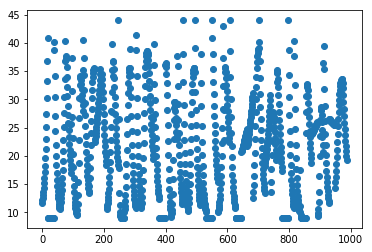

In [150]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from sklearn import preprocessing






def get_sir_trajectories(ldata):
    n= int(len(ldata)/52.0)
    season_data =  list(ldata[i:i+n] for i in range(0, len(ldata), n))


    sampled_trajectories = []
    for season in season_data:
        scale_factor= 1
        min_max_scaler = preprocessing.MinMaxScaler()

        ydata = min_max_scaler.fit_transform(season.reshape((-1,1)))
        ydata = ydata.reshape((-1))


        xdata = np.arange(1,scale_factor*len(ydata)+1,step=scale_factor)
        def sir_model(y, x, beta, gamma):
            S = -beta * y[0] * y[1] / N
            R = gamma * y[1]
            I = -(S + R)
            return S, I, R

        def fit_odeint(x, beta, gamma):
            return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

        N = 1.0
        I0 = ydata[0]
        S0 = N - I0
        R0 = 0.0
        popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
        fitted = fit_odeint(xdata, *popt)
        sampled_trajectories.append(fitted)
    
    wtf = np.array(sampled_trajectories).flatten().tolist()
    wtf = np.array(wtf).reshape((1,-1))
    tmp = min_max_scaler.inverse_transform(wtf)
    return tmp.reshape((-1,))
local_sampled_trajectories= get_sir_trajectories(data)
plt.plot(local_sampled_trajectories, 'o')
plt.show()

In [149]:
local_data = data[:len(data)-4*52]
print(len(local_data))
ll_sampled_trajectories= get_sir_trajectories(local_data)

780
780


SystemExit: 

In [43]:



X,y = create_lag_training_set(sampled_trajectories)

x_train = X[:len(X)-20]
x_test= X[len(X)-20:]
y_train= y[:len(X)-20]
y_test = y[len(X)-20:]
from keras.layers.core import Lambda
from keras import backend as K

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(4,)))
model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))


    
model.layers[0].trainable = False

/Users/gcgibson/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 512)               2560      
_________________________________________________________________
lambda_30 (Lambda)           (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 513       
Total params: 265,729
Trainable params: 265,729
Non-trainable params: 0
_________________________________________________________________


In [44]:
X,y = create_lag_training_set(data)

x_train = X[:len(X)-20]
x_test= X[len(X)-20:]
y_train= y[:len(X)-20]
y_test = y[len(X)-20:]
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0)


In [45]:
nn_pred = []
num_mcmc_samples = 100
for s in range(num_mcmc_samples):
    nn_pred.append(model.predict(x_test))
nn_pred_mean_sir = np.mean(nn_pred,axis=0)

In [46]:
print ("SIR-NN:",mean_squared_error(nn_pred_mean_sir,y_test))
print ("AR",mean_squared_error(ar_predictions,y_test))
print ("NN:",mean_squared_error(nn_pred_mean,y_test))

('SIR-NN:', 102.708534)
('AR', 162.89510262716323)
('NN:', 91.612465)


We now run this multiple times 

In [159]:
def nn_no_sir(x_train,x_test,y_train,y_test):
    model = Sequential()
    model.add(Dense(512, activation='tanh', input_shape=(4,)))
    model.add(Lambda(lambda x: K.dropout(x, level=0.1)))
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(1, activation='linear'))


    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=100,
                        verbose=0,
                        validation_data=(x_test, y_test))

    nn_pred = []
    num_mcmc_samples = 100
    for s in range(num_mcmc_samples):
        nn_pred.append(model.predict(x_test))
    nn_pred_mean = np.mean(nn_pred,axis=0)
    return nn_pred_mean

In [162]:
def nn_w_sir(x_train,x_test,y_train,y_test,data,cutoff):
    local_data = data[:len(data)-cutoff]
    ll_sampled_trajectories= get_sir_trajectories(local_data)
 
    X,y = create_lag_training_set(ll_sampled_trajectories)

    x_train = X[:len(X)-20]
    x_test= X[len(X)-20:]
    y_train= y[:len(X)-20]
    y_test = y[len(X)-20:]
    model = Sequential()
    model.add(Dense(512, activation='tanh', input_shape=(4,)))
    model.add(Lambda(lambda x: K.dropout(x, level=0.1)))
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(1, activation='linear'))


    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=90,
                        verbose=0,
                        validation_data=(x_test, y_test))
    model.layers[0].trainable = False
    X,y = create_lag_training_set(local_data)

    x_train = X[:len(X)-20]
    x_test= X[len(X)-20:]
    y_train= y[:len(X)-20]
    y_test = y[len(X)-20:]
    model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        verbose=0)
    nn_pred = []
    num_mcmc_samples = 100
    for s in range(num_mcmc_samples):
        nn_pred.append(model.predict(x_test))
    nn_pred_mean_sir = np.mean(nn_pred,axis=0)
    return nn_pred_mean_sir

In [ ]:
def run_experiment(cutoff=0):
    

  
    X,y = create_lag_training_set(local_data)
    x_train = X[:len(X)-20]
    x_test= X[len(X)-20:]
    y_train= y[:len(X)-20]
    y_test = y[len(X)-20:]
   
    nn_no_sir_pred = nn_no_sir(x_train,x_test,y_train,y_test)
    nn_w_sir_pred = nn_w_sir(x_train,x_test,y_train,y_test,data,cutoff)

    return mean_squared_error(nn_w_sir_pred,y_test),mean_squared_error(nn_no_sir_pred,y_test)

total_nn = 0
total_sir_nn = 0 
for i in range(4*52,12*52,52):
    nn,sir_nn = run_experiment(i)
    print (nn,sir_nn)
    total_nn +=nn
    total_sir_nn += sir_nn
    
print (total_nn,total_sir_nn)